# Imports

In [20]:
import tensorflow as tf
import tensorflow_datasets as tfds

import keras_tuner as kt

import numpy as np

import matplotlib.pyplot as plt

from functools import partial

# 9. Custom CNN

Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST.

## Load the Dataset

In [2]:
mnist = tf.keras.datasets.mnist.load_data()

## Split the Dataset

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = mnist

In [4]:
valid_size = 10_000

X_train, y_train = X_train_full[:-valid_size], y_train_full[:-valid_size]
X_valid, y_valid = X_train_full[-valid_size:], y_train_full[-valid_size:]

## Rescale the Data

The images need to be rescaled to be in between 0 and 1.

In [5]:
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

## Transform to `tf.data`

Because the dataset can fit into memory, I will let the `tf.data` version also be completely in memory.

Also, the data has already been shuffled, so there is no need to do any of this.

In [6]:
batch_size = 32

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).cache()
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(batch_size).cache()
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).cache()

## Building the Model

### SE Block

In [37]:
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, input_size:int, squeeze_factor:int, **kwargs):
        super().__init__(**kwargs)

        squeeze_neurons = np.ceil(input_size / squeeze_factor)
        
        self.layers = [
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Reshape((1, 1, input_size)),
            tf.keras.layers.Dense(squeeze_neurons, activation="relu", kernel_initializer="he_normal"),
            tf.keras.layers.Dense(input_size, activation="sigmoid")
        ]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.layers:
            Z = layer(Z)
        
        return Z

### Residual Unit

In [8]:
class ResidualUnit(tf.keras.layers.Layer):
    DefaultConv2D = partial(tf.keras.layers.Conv2D,
                            kernel_size=3, strides=1,
                            padding="same",
                            kernel_initializer="he_normal",
                            use_bias=False)
    
    def __init__(self, filters: int, strides:int=1, activation:str="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation_func = tf.keras.activations.get(activation)

        self.main_layers = [
            ResidualUnit.DefaultConv2D(filters=filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(self.activation_func),
            ResidualUnit.DefaultConv2D(filters=filters),
            tf.keras.layers.BatchNormalization()
        ]

        self.skip_layers = []
        if strides != 1:
            self.skip_layers = [
                ResidualUnit.DefaultConv2D(filters=filters, strides=strides, kernel_size=1),
                tf.keras.layers.BatchNormalization()
            ]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        
        Z_skip = inputs
        for layer in self.skip_layers:
            Z_skip = layer(Z_skip)
        
        Z_sum = Z + Z_skip

        return self.activation_func(Z_sum)

### SE-ResNet Unit

In [44]:
class SEResNetUnit(tf.keras.layers.Layer):
    def __init__(self, filters:int, strides:int=1, activation:str="relu", squeeze_factor:int=16, **kwargs):
        super().__init__(**kwargs)

        self.se_block = SEBlock(input_size=filters, squeeze_factor=squeeze_factor)
        self.re_unit = ResidualUnit(filters=filters, strides=strides, activation=activation)

        self.skip_layers = []
        if strides != 1:
            self.skip_layers = [
                ResidualUnit.DefaultConv2D(filters=filters, strides=strides, kernel_size=1),
                tf.keras.layers.BatchNormalization()
            ]
    
    def call(self, inputs):
        Z = inputs

        Z_res = self.re_unit(Z)
        Z_recal = Z_res * self.se_block(Z_res)

        Z_skip = inputs
        for layer in self.skip_layers:
            Z_skip = layer(Z_skip)
        
        return Z_skip + Z_recal
        

### Model Based on SENet

In [125]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((28, 28, 1), input_shape=(28,28)),
        ResidualUnit.DefaultConv2D(filters=32, strides=2, kernel_size=7),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
        SEResNetUnit(filters=32, strides=1, squeeze_factor=16),
        SEResNetUnit(filters=32, strides=1, squeeze_factor=16),
        SEResNetUnit(filters=64, strides=2, squeeze_factor=16),
        SEResNetUnit(filters=64, strides=1, squeeze_factor=16),
        SEResNetUnit(filters=128, strides=2, squeeze_factor=16),
        SEResNetUnit(filters=128, strides=1, squeeze_factor=16),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(rate=0.4),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

    return model

## Finding Learning Rate

In [126]:
def build_tuner_model(hp: kt.HyperParameters):
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")

    model = build_model()

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Nadam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [129]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

baysian_opt_tuner = kt.BayesianOptimization(
    build_tuner_model,
    objective="val_accuracy", seed=42,
    max_trials=10,
    overwrite=True, directory="my_fashion", project_name="baysian_opt"
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3)

sample_size = 3_000
n_sample_batches = np.ceil(sample_size / batch_size)

train_sample = train_set.take(n_sample_batches)
valid_sample = valid_set.take(n_sample_batches)

baysian_opt_tuner.search(
    train_sample, epochs=10,
    validation_data=valid_sample,
    callbacks=[early_stopping_cb]
)

Trial 10 Complete [00h 00m 28s]
val_accuracy: 0.9604388475418091

Best val_accuracy So Far: 0.9604388475418091
Total elapsed time: 00h 04m 09s


In [130]:
baysian_opt_tuner.get_best_hyperparameters()[0].values

{'learning_rate': 0.0005835805243232947}

## One Cycle

In [2]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations:int, max_lr:float=1e-3, start_lr:float=None, last_iterations:int=None, last_lr:float=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or self.max_lr / 10.0
        self.last_iterations = last_iterations or ((iterations // 10) + 1)
        self.half_iterations = (self.iterations - self.last_iterations) // 2
        self.last_lr = last_lr or (self.start_lr / 1e3)
        self.iteration = 0

    def _interpolate(self, iter1:int, iter2:int, lr1:float, lr2:float):
        slope = (lr2 - lr1) / (iter2 - iter1)
        return slope * (self.iteration - iter1) + lr1

    def on_batch_begin(self, batch, logs=None):
        if self.iteration < self.half_iterations:
            lr = self._interpolate(0, self.half_iterations, self.start_lr, self.max_lr)
        elif self.iteration < 2 * self.half_iterations:
            lr = self._interpolate(self.half_iterations, 2*self.half_iterations, self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2*self.half_iterations, self.iterations, self.start_lr, self.last_lr)
        
        self.iteration += 1
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)

## Train the Model

In [131]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

n_epochs = 10
n_iterations = np.ceil(len(X_train) / batch_size) * n_epochs
one_cycle_cb = OneCycleScheduler(
    iterations=n_iterations,
    max_lr=baysian_opt_tuner.get_best_hyperparameters()[0].values['learning_rate']
)
start_lr = one_cycle_cb.start_lr

model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.legacy.Nadam(learning_rate=start_lr),
    loss="sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [132]:
history = model.fit(
    train_set, epochs=n_epochs,
    validation_data=valid_set,
    callbacks=[one_cycle_cb]
)

Epoch 1/10
1563/1563 [==============================] - 34s 20ms/step - loss: 0.4477 - accuracy: 0.8611 - val_loss: 0.0983 - val_accuracy: 0.9703
Epoch 2/10
1563/1563 [==============================] - 32s 20ms/step - loss: 0.1035 - accuracy: 0.9692 - val_loss: 0.0696 - val_accuracy: 0.9787
Epoch 3/10
1563/1563 [==============================] - 32s 20ms/step - loss: 0.0671 - accuracy: 0.9799 - val_loss: 0.0743 - val_accuracy: 0.9775
Epoch 4/10
1563/1563 [==============================] - 32s 20ms/step - loss: 0.0521 - accuracy: 0.9840 - val_loss: 0.0741 - val_accuracy: 0.9798
Epoch 5/10
1563/1563 [==============================] - 32s 20ms/step - loss: 0.0418 - accuracy: 0.9870 - val_loss: 0.0555 - val_accuracy: 0.9841
Epoch 6/10
1563/1563 [==============================] - 32s 21ms/step - loss: 0.0271 - accuracy: 0.9913 - val_loss: 0.0502 - val_accuracy: 0.9872
Epoch 7/10
1563/1563 [==============================] - 32s 21ms/step - loss: 0.0158 - accuracy: 0.9952 - val_loss: 0.0513 -

In [133]:
model.evaluate(test_set)

313/313 [==============================] - 2s 5ms/step - loss: 0.0309 - accuracy: 0.9919


[0.030881082639098167, 0.9919000267982483]

# 10. Transfer Learning

In [3]:
tf.keras.backend.clear_session()

## Create Training Set

Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the locatoin (beach, mountain, city, etc.), or alternitavely you can use an existing dataset (e.g. from TensorFlow Datasets).

In [4]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [5]:
dataset_size = info.splits['train'].num_examples
class_names = info.features['label'].names
n_classes = info.features['label'].num_classes

In [6]:
print(f"Num samples: {dataset_size}")
print(f"Num Classes: {n_classes}")
print(f"Class Names: {class_names}")

Num samples: 3670
Num Classes: 5
Class Names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


## Split Data

Split the data into a training set, a validation set, and a test set.

In [7]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

## Preprocessing

Build the input pipeline, apply the appropriate preprocessing operations, and optionally add data augmentation.

In [8]:
batch_size = 32

preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.efficientnet_v2.preprocess_input)
])

In [9]:
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

In [11]:
train_set_augmented = train_set.map(lambda X, y: (data_augmentation(X), y))

## Fine-tune Pretrained Model

Fine-tune a pretrained model on this dataset.

### Model Creation

In [204]:

base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet")

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

### Initial Training

In [205]:
for layer in base_model.layers:
    layer.trainable = False

In [206]:
optimizer = tf.keras.optimizers.legacy.Nadam()

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [207]:
max_epochs = 10

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, min_delta=1e-2)

history = model.fit(
    train_set_augmented, epochs=max_epochs,
    validation_data=valid_set,
    callbacks=[early_stopping_cb]
)

Epoch 1/10
86/86 [==============================] - 42s 435ms/step - loss: 0.8243 - accuracy: 0.7351 - val_loss: 0.4840 - val_accuracy: 0.8730
Epoch 2/10
86/86 [==============================] - 37s 426ms/step - loss: 0.3980 - accuracy: 0.8826 - val_loss: 0.3704 - val_accuracy: 0.8911
Epoch 3/10
86/86 [==============================] - 37s 433ms/step - loss: 0.3093 - accuracy: 0.9146 - val_loss: 0.3294 - val_accuracy: 0.9020
Epoch 4/10
86/86 [==============================] - 38s 441ms/step - loss: 0.2557 - accuracy: 0.9255 - val_loss: 0.3033 - val_accuracy: 0.9074
Epoch 5/10
86/86 [==============================] - 37s 433ms/step - loss: 0.2290 - accuracy: 0.9328 - val_loss: 0.2887 - val_accuracy: 0.9111
Epoch 6/10
86/86 [==============================] - 37s 433ms/step - loss: 0.1979 - accuracy: 0.9433 - val_loss: 0.2791 - val_accuracy: 0.9147
Epoch 7/10
86/86 [==============================] - 38s 437ms/step - loss: 0.1795 - accuracy: 0.9513 - val_loss: 0.2734 - val_accuracy: 0.9147

### Further Training

In [211]:
for indices in zip(range(54), range(54, 108), range(108, 162), range(162, 216), range(216, 269)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:25}", end="")
    print()

  0: input_1                   54: block4b_se_reduce        108: block5c_bn               162: block6b_expand_conv      216: block6e_se_expand        
  1: rescaling                 55: block4b_se_expand        109: block5c_activation       163: block6b_expand_bn        217: block6e_se_excite        
  2: normalization             56: block4b_se_excite        110: block5c_se_squeeze       164: block6b_expand_activation218: block6e_project_conv     
  3: stem_conv                 57: block4b_project_conv     111: block5c_se_reshape       165: block6b_dwconv2          219: block6e_project_bn       
  4: stem_bn                   58: block4b_project_bn       112: block5c_se_reduce        166: block6b_bn               220: block6e_drop             
  5: stem_activation           59: block4b_drop             113: block5c_se_expand        167: block6b_activation       221: block6e_add              
  6: block1a_project_conv      60: block4b_add              114: block5c_se_excite        168:

In [212]:
for layer in base_model.layers[149:]:
    layer.trainable = True

In [213]:
model.save("my_flower_initial")

INFO:tensorflow:Assets written to: my_flower_initial/assets


INFO:tensorflow:Assets written to: my_flower_initial/assets


In [12]:
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet")

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

loaded_model = tf.keras.models.load_model("my_flower_initial")

model.set_weights(loaded_model.get_weights())

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[149:]:
    layer.trainable = True

In [13]:
tf.random.set_seed(42)

max_lr = 9e-5

n_epochs = 10
n_iterations = np.ceil(dataset_size / batch_size) * n_epochs
one_cycle_cb = OneCycleScheduler(
    iterations=n_iterations,
    max_lr=max_lr
)
start_lr = one_cycle_cb.start_lr

model.compile(
    optimizer=tf.keras.optimizers.legacy.Nadam(learning_rate=start_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [15]:
model.fit(
    train_set_augmented, epochs=n_epochs,
    validation_data=valid_set,
    callbacks=[one_cycle_cb]
)

Epoch 1/10
86/86 [==============================] - 61s 645ms/step - loss: 0.4226 - accuracy: 0.8794 - val_loss: 0.3798 - val_accuracy: 0.8784
Epoch 2/10
86/86 [==============================] - 55s 632ms/step - loss: 0.3009 - accuracy: 0.9193 - val_loss: 0.3076 - val_accuracy: 0.8984
Epoch 3/10
86/86 [==============================] - 59s 677ms/step - loss: 0.2096 - accuracy: 0.9477 - val_loss: 0.2517 - val_accuracy: 0.9147
Epoch 4/10
86/86 [==============================] - 56s 649ms/step - loss: 0.1539 - accuracy: 0.9622 - val_loss: 0.2195 - val_accuracy: 0.9201
Epoch 5/10
86/86 [==============================] - 57s 665ms/step - loss: 0.1120 - accuracy: 0.9702 - val_loss: 0.1897 - val_accuracy: 0.9347
Epoch 6/10
86/86 [==============================] - 58s 671ms/step - loss: 0.0915 - accuracy: 0.9760 - val_loss: 0.1767 - val_accuracy: 0.9401
Epoch 7/10
86/86 [==============================] - 59s 683ms/step - loss: 0.0611 - accuracy: 0.9862 - val_loss: 0.1720 - val_accuracy: 0.9401

In [16]:
model.save("my_flower_trained")

INFO:tensorflow:Assets written to: my_flower_trained/assets


INFO:tensorflow:Assets written to: my_flower_trained/assets


## Evaluating the Model

In [18]:
model = tf.keras.models.load_model("my_flower_trained")
for layer in model.layers:
    layer.trainable = False

In [19]:
model.evaluate(test_set)

12/12 [==============================] - 4s 271ms/step - loss: 0.1692 - accuracy: 0.9564


[0.16924694180488586, 0.9564032554626465]

1/1 [==============================] - 0s 326ms/step


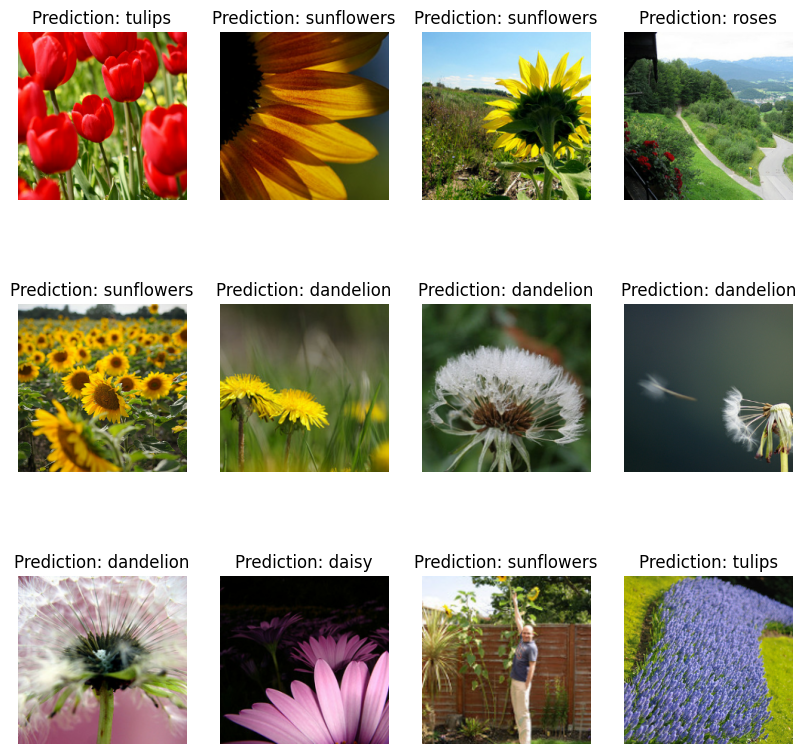

In [43]:
test_size = len(test_set)
n_cols = 4
n_rows = 3

plt.figure(figsize=(10,10))

for X_batch, y_batch in test_set.take(1):
    y_pred = model.predict(X_batch).argmax(axis=-1)
    for imgIdx in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, imgIdx+1)
        plt.imshow((X_batch[imgIdx] / 255.))
        title_color = "black" if y_pred[imgIdx] == y_batch[imgIdx] else "red"
        plt.title(f"Prediction: {class_names[y_pred[imgIdx]]}", color=title_color)
        plt.axis("off")

plt.show()